### T-cell OSCC heatmap results

In [ ]:
# requires(c('FNN','dplyr','matrixStats', 'limma', 'msImpute'))

#### Load saved embedding and preprocess

In [1]:
query_embedding <- read.csv('~/ion_mobility/peptideprotonet_embedding_space_90Kto20KsplitTrain_epoch300_featuresScaled_TCellsCancer_noEvidenceTrain.csv')

refrence_data <- read.csv('~/ion_mobility/peptideprotonet_embedding_space_90Kto20KsplitTrain_epoch300_featuresScaled_EvidenceTrain.csv')

tcells_evidence <- read.delim("~/ion_mobility/PXD023049/txt/evidence.txt")
tcells_evidence$PrecursorID <- paste(tcells_evidence$Modified.sequence, tcells_evidence$Charge, sep="")
tcells_evidence$Species <- "Human"

query <- query_embedding # grep("dim|Raw.file", colnames(data))
reference <- refrence_data #  grep("dim", colnames(data))
query$Raw.file.id <- as.numeric(as.factor(query$Raw.file))
tcells_evidence$Raw.file.id <- as.numeric(as.factor(tcells_evidence$Raw.file))


lc_ms_anchors  <- c("Raw.file.id", "Charge","m.z", "Mass", "Intensity","Retention.time")
identified_peptides <- FNN::get.knnx(query[, lc_ms_anchors], tcells_evidence[, lc_ms_anchors], k=1)
identified_peptides <- query[identified_peptides$nn.index,]
identified_peptides$PrecursorID <- tcells_evidence$PrecursorID
identified_peptides$Species <- tcells_evidence$Species


unidentified_peptides <- dplyr::anti_join(query, identified_peptides,
                                            by = lc_ms_anchors)



reference_combined <- rbind(reference[,c(grep("dim", colnames(reference), value = TRUE), "Charge", "PrecursorID", "Species")],
                            identified_peptides[,c(grep("dim", colnames(reference), value = TRUE), "Charge" ,"PrecursorID", "Species")])
                            
unidentified_peptides_latent <- unidentified_peptides[, grep("dim", colnames(unidentified_peptides))]


reference_latent <- reference_combined[, grep("dim", colnames(reference_combined))]
reference_charge <- reference_combined$Charge
reference_ident_labels <- reference_combined$PrecursorID
reference_ident_species <- reference_combined$Species


all_unidentified_peptides <- unidentified_peptides

In [2]:
reference_combined_sub <- reference_combined[reference_combined$Species %in% c("HeLa","Yeast"), ] # c("HeLa","Human","Yeast")
reference_latent <- reference_combined_sub[, grep("dim", colnames(reference_combined_sub))]
#reference_latent <- t(apply(reference_latent, 1, FUN=function(x) x/sqrt(sum(x^2))))
reference_charge <- reference_combined_sub$Charge
reference_ident_labels <- reference_combined_sub$PrecursorID
reference_ident_species <- reference_combined_sub$Species



study_embedding <- reference_combined[reference_combined$Species %in% c("Human","Yeast"), ] # c("HeLa","Human","Yeast")
study_latent <- study_embedding[, grep("dim", colnames(study_embedding))]
#study_latent <- t(apply(study_latent, 1, FUN=function(x) x/sqrt(sum(x^2)) ))
study_charge <- study_embedding$Charge
study_ident_labels <- study_embedding$PrecursorID
study_ident_species <- study_embedding$Species



tcells_evidence_dedupped <- tcells_evidence[, c("Raw.file","PrecursorID")]
tcells_evidence_dedupped <- tcells_evidence_dedupped[!duplicated(tcells_evidence_dedupped),]
# tcells_evidence_dedupped <- tcells_evidence_dedupped[grep("ox|Deamidation|Acetyl|Oxidation|ac", tcells_evidence_dedupped$PrecursorID, invert=TRUE),]

Use `computeStats()` for label (peptide identity propagation) and computing false transfers, coverage, new identifications transferred etc 

In [3]:
computeStats <- function(thr, k){
  
  false_transfer_rate <- c()
  # coverage_per_run <- c()
  total_idents_per_run_after_transfer <- c()
  number_new_ident <- c()
  coverage_per_run_after_transfer <- c()
  coverage_per_run_before_transfer <- c()
  ident_list <- list()
  
  itr = 1
  
  for (run in unique(tcells_evidence_dedupped$Raw.file)){
    
    message(run)
    missing_idents <- setdiff(tcells_evidence_dedupped$PrecursorID,
                              tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file == run])
  
    latent_study <- study_latent[study_embedding$PrecursorID %in% missing_idents,]
    s_charge <- study_charge[study_embedding$PrecursorID %in% missing_idents]
    s_ident_labels <- study_ident_labels[study_embedding$PrecursorID %in% missing_idents]
    s_ident_species <- study_ident_species[study_embedding$PrecursorID %in% missing_idents]
  
  
    run_query_peptides <- unidentified_peptides[unidentified_peptides$Raw.file %in% run,]
  
    run_query_peptides_latent <- run_query_peptides[, grep("dim", colnames(run_query_peptides))]
    #run_query_peptides_latent <- t(apply(run_query_peptides_latent, 1, FUN=function(x) x/sqrt(sum(x^2))))
    query_feature_charges <- run_query_peptides$Charge
    run_query_peptides_intensity <- run_query_peptides$Intensity
  
  
    knn_prototypes <- FNN::get.knnx(

        latent_study,
        run_query_peptides_latent,
      k = k) 
  
    probs <- exp(-0.5*((knn_prototypes$nn.dist^2)/matrixStats::rowSds(knn_prototypes$nn.dist^2)))
    # probs <- 1 - knn_prototypes$nn.dist^2
    ww <- matrix(s_charge[knn_prototypes$nn.index], nrow = nrow(probs), ncol = ncol(probs))
    charge <- matrix(query_feature_charges, nrow = nrow(ww), ncol = ncol(ww), byrow = FALSE)
    w <- ifelse(ww==charge, 1, 0)
  
  
  
  
  
    transferred_idents <- matrix(s_ident_labels[knn_prototypes$nn.index], 
                               nrow = nrow(probs), ncol = ncol(probs))
    transferred_species <- matrix(s_ident_species[knn_prototypes$nn.index], 
                                nrow = nrow(probs), ncol = ncol(probs))


    # probs <- w*probs
    # probs <- probs/rowSums(probs)
    # probs[!is.finite(probs)] <- 0

    transferred_idents[w==0] <- "other"
    transferred_species[w==0] <- "other"


    unmapped_queries <- (rowSums(probs < thr) == k)
    
    false_transfers_co <- which(rowSums(probs >= thr & transferred_species == c("Yeast") ) > 1)
    length(false_transfers_co)
  
  
    correct_transfers <-  (rowSums(probs >= thr & (transferred_species == "Human" | transferred_species == "HeLa") )> 2)
    correct_transfers_run_names <- run_query_peptides$Raw.file[correct_transfers]
    correct_transfer_idents <- transferred_idents[correct_transfers,]
    correct_transfer_idents <- apply(correct_transfer_idents,1, FUN=function(x) {
      z <- table(x)
      z <- z[!grepl("other", names(z))]
      names(z)[which.max(z)]}
      )
  
    #correct_transfer_idents <- gsub("__","_",correct_transfer_idents)
    transfer_idents <- do.call(cbind, list(correct_transfers_run_names, correct_transfer_idents,
                                           run_query_peptides_intensity[correct_transfers]))
    transfer_idents <- data.frame(transfer_idents)
    colnames(transfer_idents) <- c("Raw.file","PrecursorID","Intensity")
    # transfer_idents$PrecursorID <- gsub("__","_", transfer_idents$PrecursorID)
  
    
    
    ### computation of false transfers-------
    
    # false_transfer_rate[itr] <- length(false_transfers)
    
    query_feature_charges <- run_query_peptides$Charge[unmapped_queries]
    unmapped_queries_latent <- run_query_peptides_latent[unmapped_queries,]
    unmapped_queries_inetnsity <- run_query_peptides_intensity[unmapped_queries]
    
    if(nrow(unmapped_queries_latent) > 0 ) {
      
      
      ex_prototypes <- FNN::get.knnx(

        reference_latent,
        unmapped_queries_latent,
      k = k) 
  
    ex_probs <- exp(-0.5*((ex_prototypes$nn.dist^2)/matrixStats::rowSds(ex_prototypes$nn.dist^2)))
    # ex_probs <- 1 - ex_prototypes$nn.dist^2
    ww2 <- matrix(reference_charge[ex_prototypes$nn.index], nrow = nrow(ex_probs), ncol = ncol(ex_probs))
    charge_ex <- matrix(query_feature_charges, nrow = nrow(ww2), ncol = ncol(ww2), byrow = FALSE)
    w2 <- ifelse(ww2==charge_ex, 1, 0)
  
  
  
  
  
    transferred_idents <- matrix(reference_ident_labels[ex_prototypes$nn.index], 
                               nrow = nrow(ex_probs), ncol = ncol(ex_probs))
    transferred_species <- matrix(reference_ident_species[ex_prototypes$nn.index], 
                                nrow = nrow(ex_probs), ncol = ncol(ex_probs))


    #ex_probs <- w2*ex_probs
    #ex_probs <- ex_probs/rowSums(ex_probs)
    # ex_probs[!is.finite(ex_probs)] <- 0

    transferred_idents[w2==0] <- "other"
    transferred_species[w2==0] <- "other"
    
    
    false_transfers <- which(rowSums(ex_probs >= thr & transferred_species == c("Yeast")) > 1)
    length(false_transfers)
    
    
    
    new_transfers <- which(rowSums(ex_probs >= thr & (transferred_species == "HeLa") ) > 1)
    length(new_transfers)
    
    if(length(new_transfers) > 0){
      
      new_transfers_run_names <- run_query_peptides$Raw.file[unmapped_queries][new_transfers]
      new_transfer_idents <- transferred_idents[new_transfers,, drop=FALSE]
      new_transfer_idents <- apply(new_transfer_idents,1, FUN=function(x) {
        z <- table(x)
        z <- z[!grepl("other", names(z))]
        names(z)[which.max(z)]
        }
      )
  
      new_transfer_idents <- gsub("__","_", new_transfer_idents)
      transfer_idents2 <- do.call(cbind, list(new_transfers_run_names, new_transfer_idents,
                                              unmapped_queries_inetnsity[new_transfers]))
      transfer_idents2 <- data.frame(transfer_idents2)
      colnames(transfer_idents2) <- c("Raw.file","PrecursorID","Intensity")
      # transfer_idents2$PrecursorID <- gsub("__","_", transfer_idents2$PrecursorID)
  
      total_transferred_idents <- rbind(transfer_idents2, transfer_idents)
      number_new_ident[itr] <- length(setdiff(transfer_idents2$PrecursorID, tcells_evidence_dedupped$PrecursorID))
    } else {
      total_transferred_idents <- transfer_idents
      number_new_ident[itr] <- 0
    }
    
     
    false_transfers <- c(false_transfers, false_transfers_co)
    false_transfer_rate[itr] <- length(false_transfers)/length(union(total_transferred_idents$PrecursorID,
                                                                      tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run]))
     
    } else{
      
      
      
      total_transferred_idents <- transfer_idents
      false_transfer_rate[itr] <- length(false_transfers_co)/length(union(total_transferred_idents$PrecursorID,
                                                                      tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run]))
      number_new_ident[itr] <- 0
      
    }
    
     
    
    
    
    # need to store raw file, precursor and Intensity
    all_idents <- rbind(cbind(tcells_evidence[tcells_evidence$Raw.file %in% run, 
                                        c("Raw.file","PrecursorID","Intensity")],
                              type = "TIMS-MULTI-MSMS"),
                        cbind(total_transferred_idents, type = "PIP")
    )
    
    all_idents_in_run <- union(total_transferred_idents$PrecursorID,
                               tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run])
    
    coverage_per_run_after_transfer[itr] <- length(intersect(all_idents_in_run, tcells_evidence_dedupped$PrecursorID))/ length(unique(tcells_evidence_dedupped$PrecursorID))
    
    
    coverage_per_run_before_transfer[itr] <- length(intersect(tcells_evidence_dedupped$PrecursorID[tcells_evidence_dedupped$Raw.file %in% run], tcells_evidence_dedupped$PrecursorID))/ length(unique(tcells_evidence_dedupped$PrecursorID))
    
    

    total_idents_per_run_after_transfer[itr] <- length(all_idents_in_run)
    ident_list[[itr]] <- data.frame(all_idents)

   
    
    itr = itr + 1
     
    
  
  }
  
  ALL_IDENTS <- do.call(rbind, ident_list)
  return(list("threshold" = rep(thr, length(unique(tcells_evidence_dedupped$Raw.file))), 
              "false_transfer_rate" = false_transfer_rate, 
                         #"median_coverage" = med_cov_per_run, 
              "coverage_before_transfer" = coverage_per_run_before_transfer,
              "coverage_after_transfer" = coverage_per_run_after_transfer,
              "number_new_idents" = number_new_ident,
              "total_idents_per_run_after_PIP" = total_idents_per_run_after_transfer,
              "identifications" = ALL_IDENTS))
}

Quantify PIPP for $k=10$ and uncertainty cutoff zero:

ℹ Loading msImpute




TIMS-MULTI-MSMS 
         108018 

[1] 30843

Control_secretoma1_Slot2-19_1_2497

Control_secretoma2_Slot2-19_1_2498

Control_secretoma3_Slot2-19_1_2499

Cancer_secretoma2_Slot2-20_1_2502

Cancer_secretoma1_Slot2-20_1_2501

Cancer_secretoma3_Slot2-20_1_2503




            PIP TIMS-MULTI-MSMS 
         378854          108018 

[1] 108018     76

[1] 23399.5

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20835   21173   23400   23304   25524   25530 

[1] 16770.5

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14429   14720   16770   16705   18766   18791 

[1] 30843     6

[1] 30843     6

[1] 0.2880966

[1] 0.7038822

[1] 0.7797585

[1] 7728

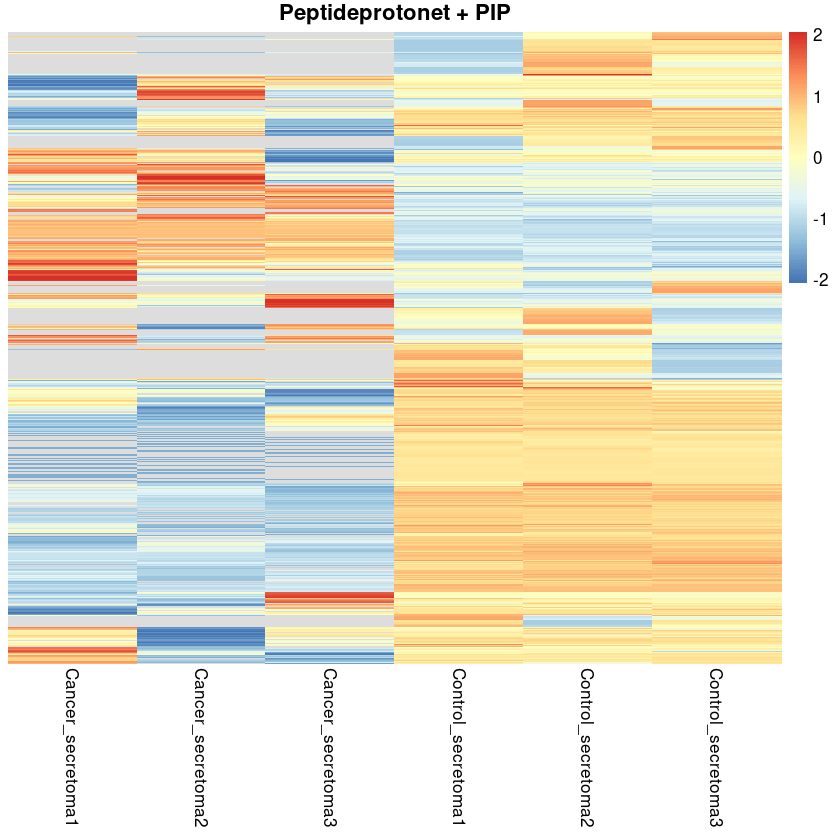

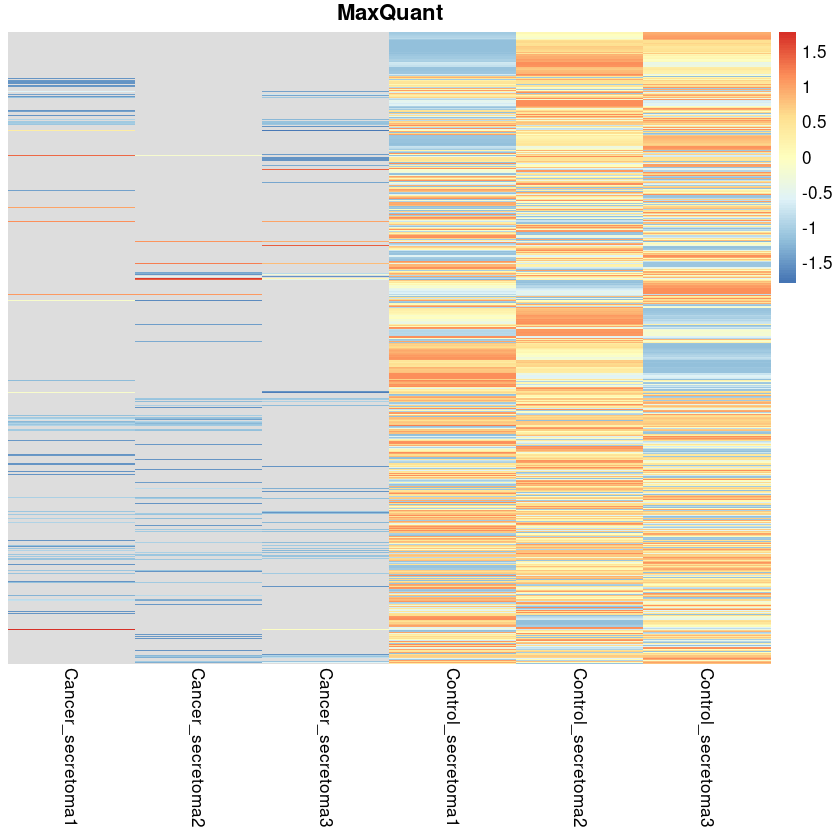

In [4]:
devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")
data <- read.delim("~/ion_mobility/PXD023049/txt/evidence.txt", 
                   stringsAsFactors = FALSE)


table(data$Type)

data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")


length(unique(data$PeptideID))


genes <- data[,c("PeptideID","matrix.row.id", "Leading.razor.protein")]
genes <- genes[!duplicated(genes),]






tcells_pip_k10_cut005 <- computeStats(0, k = 10)

z <- tcells_pip_k10_cut005$identifications
table(z$type)
dim(data)


z$Intensity <- as.numeric(z$Intensity)

y_pip <- evidenceToMatrix(z, peptide_id = "PrecursorID")

# y_pip["_AAAANLCPGDVILAIDGFGTESMTHADAQDR_3",]
# z[z$PrecursorID %in% "_AAAANLCPGDVILAIDGFGTESMTHADAQDR_3",]


median(colSums(!is.na(y_pip)))
summary(colSums(!is.na(y_pip)))




y_noMBR <- evidenceToMatrix(data)
# what is median identifications per run
median(colSums(!is.na(y_noMBR)))
summary(colSums(!is.na(y_noMBR)))


dim(y_noMBR)
dim(y_pip)


# drop modifications
y_noMBR <- y_noMBR[grep("[a-z]+", rownames(y_noMBR), invert = TRUE),]
y_pip <- y_pip[grep("[a-z]+", rownames(y_pip), invert = TRUE),]

## filter out some rows/entries ----

y_noMBR <- y_noMBR[rowSums(!is.na(y_noMBR)) > 2,]
y_pip <- y_pip[rowSums(!is.na(y_pip)) > 2,]

mean(complete.cases(y_noMBR))
mean(complete.cases(y_pip))
mean(complete.cases(y_pip[rownames(y_noMBR),]))



missing_peptides <- rownames(y_noMBR)[!complete.cases(y_noMBR[,1:3]) & complete.cases(y_noMBR[,4:6])]
length(missing_peptides)

library(pheatmap)

z1 <- t(scale(t(log2(y_noMBR))))
z2 <- t(scale(t(log2(y_pip))))

# z1 <- log2(y_noMBR)
# z2 <- log2(y_pip)




pheatobj <- pheatmap(z2[missing_peptides,], show_rownames = FALSE,
         treeheight_row = 0,
         treeheight_col = 0, 
         labels_col = gsub("(.*)_(.*)_(.*)_(.*)_(.*)", "\\1_\\2", colnames(z2)), 
         main = "Peptideprotonet + PIP",
         cluster_cols = FALSE,
         cluster_rows = TRUE)



 pheatmap(z1[missing_peptides,][pheatobj$tree_row$order,], show_rownames = FALSE, # [pheatobj$tree_row$order,]
         treeheight_row = 0, 
         treeheight_col = 0, 
         labels_col = gsub("(.*)_(.*)_(.*)_(.*)_(.*)", "\\1_\\2", colnames(z1)), 
         main = "MaxQuant",
         cluster_cols = FALSE,
         cluster_rows = FALSE)


Next we perform PIP for $k=10$ and $k=5$ for different cutoffs and save the results. These pre-computed results are loaded later in `peptideprotonet_PIP_evals` notebook . 

In [ ]:
############# Tabularise results for different cut-offs

results_k10 <- list()
itr = 1
for (thr in c(0, 0.01, 0.05, 0.2,0.5, 0.8)){
  res <- computeStats(thr, k = 10)
  results_k10[[itr]] <- list("threshold" = thr, "false_transfer_rate" = median(res$false_transfer_rate), 
                         "mean_coverage" = median(res$coverage_before_transfer), 
                         "mean_coverage_after_transfer" = mean(res$coverage_after_transfer),
                         "max_coverage_after_transfer" = max(res$coverage_after_transfer),
                         "N_new_idents" = round(median(res$number_new_idents)),
                         "median_idents_per_run_after_PIP" = round(median(res$total_idents_per_run_after_PIP)),
                         "identifications" = res$identifications)
  
  itr = itr + 1
  
}

coverage_results <- lapply(results_k10, FUN=function(x)  x[!grepl("identifications", names(x))])

(dt_k10 <- data.frame(do.call(rbind, coverage_results)))
dt_k10 <- data.frame(round(data.matrix(dt_k10),3))





results_5k <- list()
itr = 1
for (thr in c(0, 0.01, 0.05, 0.2,0.5, 0.8)){
  res <- computeStats(thr, k = 5)
  results_5k[[itr]] <- list("threshold" = thr, "false_transfer_rate" = median(res$false_transfer_rate), 
                         "mean_coverage" = median(res$coverage_before_transfer), 
                         "mean_coverage_after_transfer" = mean(res$coverage_after_transfer),
                         "max_coverage_after_transfer" = max(res$coverage_after_transfer),
                         "N_new_idents" = round(median(res$number_new_idents)),
                         "median_idents_per_run_after_PIP" = round(median(res$total_idents_per_run_after_PIP)),
                         "identifications" = res$identifications)
  
  itr = itr + 1
  
}

coverage_results <- lapply(results_5k, FUN=function(x)  x[!grepl("identifications", names(x))])

(dt_k5 <- data.frame(do.call(rbind, coverage_results)))
dt_k5 <- data.frame(round(data.matrix(dt_k5),3))

dt_k10_tcells <- dt_k10
dt_k5_tcells <- dt_k5

# save(dt_k10_tcells, dt_k5_tcells, file = "tcells_exosome_peptideprotonet_evals.RData")

### Session Information

In [7]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] pheatmap_1.0.12 msImpute_1.7.1 

loaded via a namespace (and not attached):
  [1] bitops_1.0-6                matrixStats_0.57.0         
  [3] fs_1.5.0                    usethis_2.0.1              
  [5] devtools_2.4.2              RCo